In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 
             7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 
             7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 
             7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 
             7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 
             7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 
             7591: 5,  7607: 40, 7621: 65, 7627: 9,  7630: 31, 
             7643: 34, 7650: 13, 7661: 83, 7690: 6,  7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Double Elements Regression

In [4]:
def init_x(data_list, consider_name):
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                one_data = [0 for i in range(len(data_list))]
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        for d in range(len(one_data)):
                            one_data[d] += data_station[consider_name[d]][k]
                    else:
                        year_position = k
                        break
                for d in range(len(one_data)):
                    data_list[d][str(provinces[i]) + "_" + str(j)] = one_data[d]
                

def init_y(data_list):
    for i in data_list[0]:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_rdt[i] = rdt[0]
                

def init_list(data_list):
    temp_data_list = []
    temp_rdt_list = []

    for i in total_rdt:
        if i in data_list[0]:
            temp_data_list.append(np.array([data_list[j][i] for j in range(len(data_list))]))
            temp_rdt_list.append(total_rdt[i])

    temp_data_list = np.array(temp_data_list)
    temp_rdt_list = np.array(temp_rdt_list)
    
    return temp_data_list, temp_rdt_list
                

def init(data_list):
    init_y(data_list)
    return init_list(data_list)

In [5]:
def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE


def predict_n(n, times, data_number):
    if n == 0:
        return predict_zero(), 0.0

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(data_number * n)])
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times


def test_degree_n(times, data_number):
    degree = np.linspace(start, end, end - start + 1)
    for i in degree:
        rRMSE_degree[crop + "_" + i.astype(int).astype(str)], coeffs[crop + "_" + i.astype(int).astype(str)] = predict_n(i.astype(int), times, data_number)


def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(start, end + 1, 1))
    
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(start, end, end - start + 1)
        for i in range(start, end + 1):
            rRMSE_plot.append(rRMSE_degree[crop + "_" + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops, loc=1)

## rr24 + DJ_0

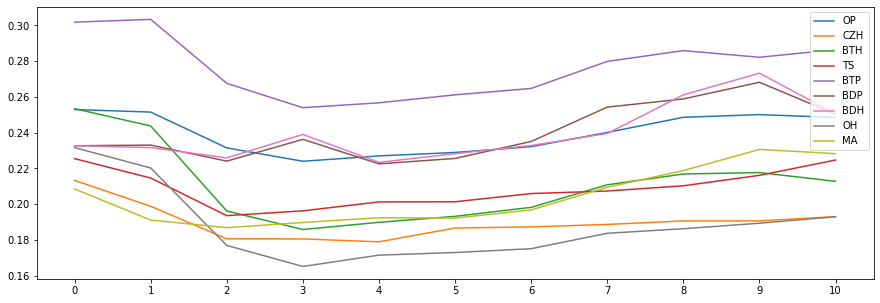

In [6]:
start = 0
end = 10
times = 1000
total_rain = {}
total_rad_0 = {}
consider_list = [total_rain, total_rad_0]

rRMSE_degree = {}
coeffs = {}

init_x(consider_list, ["rr24", "DJ_0"])

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(consider_list)

    test_degree_n(times, len(consider_list))

draw()

In [7]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(start, end + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_3': 0.22400194141856253,
 'CZH_4': 0.17899170127305478,
 'BTH_3': 0.18588934686808636,
 'TS_2': 0.19361898742554381,
 'BTP_3': 0.2539463596124466,
 'BDP_4': 0.22256369790945527,
 'BDH_4': 0.2234052621391911,
 'OH_3': 0.16522736312905884,
 'MA_2': 0.18689234310933905}

In [8]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_3': array([ 7.58247488e-08, -8.12914450e-10, -1.93721572e-04,  7.51930310e-06,
         1.47249949e-01, -2.30360557e-02]),
 'CZH_4': array([-3.66339887e-11, -1.30161769e-13,  1.32717744e-07,  1.37101844e-09,
        -1.78019799e-04, -4.27752952e-06,  1.02144377e-01,  4.87491009e-04]),
 'BTH_3': array([ 1.12019562e-07, -1.00830844e-09, -2.88133681e-04,  8.08835602e-06,
         2.24892940e-01, -2.28626044e-02]),
 'TS_2': array([-1.88128387e-05, -4.71560130e-07,  3.06665382e-02,  6.42322217e-04]),
 'BTP_3': array([ 1.48755403e-07, -1.36031352e-09, -3.66328291e-04,  1.20238665e-05,
         2.66028164e-01, -3.41010031e-02]),
 'BDP_4': array([ 3.67733497e-11, -6.63071498e-13, -8.07208700e-08,  8.09900617e-09,
         2.37579122e-05, -3.12440629e-05,  3.44548128e-02,  3.64341498e-02]),
 'BDH_4': array([ 3.81713535e-11, -6.64791340e-13, -8.33764445e-08,  8.12868827e-09,
         2.47344475e-05, -3.14278261e-05,  3.50094145e-02,  3.68667278e-02]),
 'OH_3': array([ 9.53262011e-08, -9.009

## rr24 + DJ_6

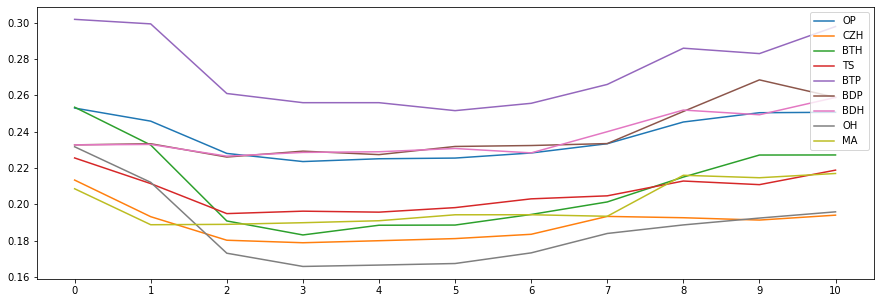

In [9]:
start = 0
end = 10
times = 1000
total_rain = {}
total_rad_6 = {}
consider_list = [total_rain, total_rad_6]

rRMSE_degree = {}
coeffs = {}

init_x(consider_list, ["rr24", "DJ_6"])

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(consider_list)

    test_degree_n(times, len(consider_list))

draw()

In [12]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(start, end + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_3': 0.22348821809842076,
 'CZH_3': 0.17881251985797675,
 'BTH_3': 0.18310018729049019,
 'TS_2': 0.19484540551683086,
 'BTP_5': 0.25150722534741976,
 'BDP_2': 0.22597002600748833,
 'BDH_2': 0.22647548165031653,
 'OH_3': 0.16576681297100945,
 'MA_1': 0.18872411611031095}

In [13]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_3': array([ 6.46828917e-08, -1.73849569e-09, -1.70521419e-04,  9.11227310e-06,
         1.33180401e-01, -1.80577405e-02]),
 'CZH_3': array([ 3.60368326e-08, -6.24777166e-10, -9.58249065e-05,  3.69430008e-06,
         7.79108124e-02, -1.14558689e-02]),
 'BTH_3': array([ 1.00266838e-07, -1.91916276e-09, -2.65281226e-04,  8.02974934e-06,
         2.12048231e-01, -1.67324744e-02]),
 'TS_2': array([-1.89897687e-05, -4.21880734e-07,  3.04639640e-02, -2.17698900e-03]),
 'BTP_5': array([-3.21011609e-13,  2.07056466e-15,  1.20485764e-09, -1.91080669e-11,
        -1.51503177e-06,  5.76221994e-08,  6.59808546e-04, -6.03416410e-05,
         2.79933526e-06,  6.59867043e-07]),
 'BDP_2': array([-2.35171831e-05, -1.25750960e-06,  3.60119771e-02,  2.38819999e-04]),
 'BDH_2': array([-2.35853607e-05, -1.28280071e-06,  3.61237345e-02,  3.57957578e-04]),
 'OH_3': array([ 8.27748590e-08, -1.32436122e-09, -2.24863665e-04,  5.13525889e-06,
         1.87610756e-01, -1.26654633e-02]),
 'MA_1': array([ 0.02